In [1225]:
import pandas as pd

# Permet veure totes les files i colummnes del dataframe.
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_colwidth', None) 
pd.set_option('display.max_rows', None)

# DF GENERACIÓ

## DF

In [1231]:
import pandas as pd
from faker import Faker
import random
from datetime import datetime, timedelta


# S'incialitza el faker en castellà
fake = Faker("es_ES")

# Funció per generar un JSON de nom complet
def generar_nom_complet():
    primer_nom = fake.first_name()
    segon_nom = fake.first_name() if random.random() <= 0.35 else ""
    primer_cognom = fake.last_name()
    segon_cognom = fake.last_name()
    
    # Concatenar el nom complet en una única cadena
    nom_complet = f"{primer_nom} {segon_nom} {primer_cognom} {segon_cognom}".strip()
    return nom_complet


codis_client = [f"C-{str(i).zfill(9)}" for i in range(1, 15001)]
noms_complets = [generar_nom_complet() for _ in codis_client]


# Es crea el df que inclou les dades de la colecció clients
df = pd.DataFrame({
    "id_client": codis_client,
    "nom_complet": noms_complets
})


def generar_email(fila):
    nom_complet = fila['nom_complet'].split()
    primer_nom = nom_complet[0].lower()
    primer_cognom = nom_complet[-2].lower()
    return f"{primer_nom}.{primer_cognom}@gmail.com"


# Afegir la columna d'email
df['email'] = df.apply(generar_email, axis=1)


In [1232]:
def generar_data_naixement():

    edat_min = 18
    edat_max = 95

    edat = random.choices(
        range(edat_min, edat_max + 1), 
        weights=[5 if 25 <= x <= 60 else (2 if 80 <= x <= 95 else 1) for x in range(edat_min, edat_max + 1)], 
        k=1
    )[0]
    
    # Càlcul de la data de naixement
    avui = datetime.now()
    any_naixement = avui.year - edat
    
    # Data de naixement aleatòria dins de l'any
    dia_naixement = random.randint(1, 365)
    data_naixement = datetime(any_naixement, 1, 1) + timedelta(days=dia_naixement - 1)
    return data_naixement.strftime('%Y-%m-%d'), edat


data_edat = [generar_data_naixement() for _ in range(len(df))]
df['data_naixement'] = [item[0] for item in data_edat]
df['edat'] = [item[1] for item in data_edat]

In [1233]:
# Columna sexe

def generar_sexe():
    return random.choices(['F', 'M', 'X'], weights=[49, 49, 2], k=1)[0]

df['sexe'] = [generar_sexe() for _ in range(len(df))]


In [1234]:
# Afegir la columna nacionalitat amb majoria Espanya

def generar_nacionalitat():
    return random.choices(
        [
            'Espanya', 'França', 'Alemanya', 'Xina', 'Japó', 'Índia', 'Itàlia', 
            'Portugal', 'Sud-àfrica', 'Rússia', 'Regne Unit', 'EEUU',
            'Brasil', 'Canadà', 'Austràlia', 'Argentina', 
            'Mèxic', 'Països Baixos', 'Suècia'
        ],
        weights=[
            80, 5, 5, 1, 1, 1, 3,  
            3, 0.5, 0.5, 2, 2, 1, 1, 
            1, 1, 0.5, 0.5, 0.5  
        ],
        k=1
    )[0]


df['nacionalitat'] = [generar_nacionalitat() for _ in range(len(df))]

In [1235]:
# Columna estat civil

def generar_estat_civil(fila):
    # Pesos segons el sexe, la nacionalitat i l'edat
    if fila['sexe'] == 'F' and fila['nacionalitat'] == 'Espanya':
        return random.choices(['Casat', 'Solter', 'Divorciat', 'Vidu'], weights=[50, 30, 15, 5], k=1)[0]
    elif fila['sexe'] == 'M' and fila['nacionalitat'] == 'Espanya':
        return random.choices(['Casat', 'Solter', 'Divorciat', 'Vidu'], weights=[40, 40, 15, 5], k=1)[0]
    else:
        return random.choices(['Casat', 'Solter', 'Divorciat', 'Vidu', 'Altres'], weights=[30, 40, 20, 5, 5], k=1)[0]

df['estat_civil'] = df.apply(generar_estat_civil, axis=1)

In [1236]:
# Columna amb el nombre de membres de la familia

def generar_membres_familia(fila):
    edat = datetime.now().year - fila['edat']
    estat_civil = fila['estat_civil']
    
    if estat_civil == 'Solter':
        return 1  # Només el client
    elif estat_civil == 'Casat':
        if edat < 30:
            return random.choices([2, 3], weights=[80, 20], k=1)[0]  # La majoria són dos membres a la familia. Estan només amb la parella.
        elif 30 <= edat <= 50:
            return random.choices([2, 3, 4, 5], weights=[20, 40, 30, 10], k=1)[0]  # En aquest rang d'edat, hi ha més famílies amb fills.
        else:
            return random.choices([2, 3], weights=[60, 40], k=1)[0]  # Menys fills a casa
    elif estat_civil == 'Divorciat':
        return random.choices([1, 2, 3], weights=[50, 30, 20], k=1)[0]
    elif estat_civil == 'Vidu':
        if edat > 60:
            return random.choices([1, 2], weights=[80, 20], k=1)[0] 
        else:
            return random.choices([1, 2, 3], weights=[30, 40, 30], k=1)[0]
    else:
        return 1

df['membres_familia'] = df.apply(generar_membres_familia, axis=1)


In [1237]:
# Columna nombre_fills

def generar_nombre_fills(fila):
    edat = fila['edat']
    estat_civil = fila['estat_civil']

    if estat_civil == 'Solter':
        return random.choices([0, 1, 2], weights=[75, 15, 10], k=1)[0]
    elif estat_civil == 'Casat':
        if edat < 25:
            return random.choices([0, 1], weights=[80, 20], k=1)[0]
        elif 25 <= edat <= 40:
            return random.choices([0, 1, 2, 3], weights=[5, 30, 45, 20], k=1)[0]
        elif 41 <= edat <= 60:
            return random.choices([0, 1, 2, 3, 4], weights=[5, 20, 30, 30, 15], k=1)[0]
        else:
            return random.choices([0, 1, 2, 3, 4], weights=[5, 20, 30, 35, 10], k=1)[0]
    elif estat_civil == 'Divorciat':
        return random.choices([0, 1, 2, 3], weights=[5, 30, 45, 20], k=1)[0]
    elif estat_civil == 'Vidu':
        if edat > 60:
            return random.choices([0, 1, 2, 3, 4], weights=[5, 20, 30, 35, 10], k=1)[0]
        else:
            return random.choices([0, 1, 2, 3], weights=[20, 40, 35, 5], k=1)[0]
    else:
        return 0

df['nombre_fills'] = df.apply(generar_nombre_fills, axis=1)

In [1238]:
# Columna tipologia d'estudis
def generar_estudis(fila):
    edat = fila['edat']
    if 16 <= edat <= 18:
        return random.choices(['Batxillerat', 'Formació Professional', 'Secundària'], weights=[40, 35, 25], k=1)[0]
    elif 19 <= edat <= 25:
        return random.choices(['Batxillerat', 'Formació Professional', 'Secundària', 'Universitat'], weights=[5, 35, 25, 35], k=1)[0]
    elif 26 <= edat <= 40:
        return random.choices(['Batxillerat', 'Formació Professional', 'Secundària', 'Universitat'], weights=[5, 30, 30, 35], k=1)[0]
    elif 41 <= edat <= 60:
        return random.choices(['Batxillerat', 'Formació Professional', 'Secundària', 'Universitat'], weights=[10, 30, 30, 30], k=1)[0]
    else:
        return random.choices(['Bàsica', 'Formació Professional', 'Secundària', 'Universitat'], weights=[10, 25, 50, 30], k=1)[0]


df['estudis'] = df.apply(generar_estudis, axis=1)

In [1239]:
# Columna historialCredit basada en factors com edat, estat civil, estudis, fills i nacionalitat

def generar_historial_credit(fila):
    edat = fila['edat']
    estat_civil = fila['estat_civil']
    nombre_fills = fila['nombre_fills']
    estudis = fila['estudis']
    nacionalitat = fila['nacionalitat']

    if edat < 25:
        if estudis in ['Batxillerat', 'Secundària']:
            return random.choices(['Reemborsat', 'Retardat', 'Crític'], weights=[30, 50, 20], k=1)[0]    
        else:
            return random.choices(['Reemborsat', 'Retardat', 'Crític'], weights=[60, 35, 5], k=1)[0]
        
    elif 25 <= edat <= 40:
        if estat_civil in ['Casat', 'Casada'] and nombre_fills > 0:
            if estudis in ['Universitària', 'Postgrau']:
                return random.choices(['Totalment reemborsat', 'Totalment reemborsat en aquest banc'], weights=[60, 40], k=1)[0]
            else:
                return random.choices(['Reemborsat', 'Retardat'], weights=[60, 40], k=1)[0]
        else:
            if nacionalitat == 'Espanya':
                return random.choices(['Reemborsat', 'Crític'], weights=[70, 30], k=1)[0]
            else:
                return random.choices(['Reemborsat', 'Retardat'], weights=[50, 50], k=1)[0]
            
    elif 41 <= edat <= 60:
        if nombre_fills > 2:
            return random.choices(['Reemborsat', 'Totalment reemborsat en aquest banc', 'Retardat', 'Crític'], weights=[45, 40, 20, 5], k=1)[0]
        else:
            return random.choices(['Reemborsat', 'Totalment reemborsat', 'Retardat', 'Crític'], weights=[45, 40, 10, 5], k=1)[0]
    else:  # Edat > 60
        if estat_civil in ['Vidu', 'Viuda']:
            return random.choices(['Totalment reemborsat', 'Totalment reemborsat en aquest banc'], weights=[50, 50], k=1)[0]
        else:
            return random.choices(['Totalment reemborsat en aquest banc', 'Reemborsat'], weights=[60, 40], k=1)[0]


df['historial_credit'] = df.apply(generar_historial_credit, axis=1)


In [1240]:
# Colummna documents_identitat

def generar_documents_identitat(fila):
    nacionalitat = fila['nacionalitat']
    documents = []

    if nacionalitat == 'Espanya':
        # Com el DNI és obligatori, tots els ciutadans espanyols tenen com a mínim aquest document d'identitat.
        documents.append({
            "tipus_document": "dni",
            "nombre_document": f"{random.randint(10000000, 99999999)}{random.choice('TRWAGMYFPDXBNJZSQVHLCKE')}"
        })

        if random.random() < 0.5:
            documents.append({
                "tipus_document": "passaport",
                "nombre_document": f"{random.choice('ABCDEFGHIJKLMNOPQRSTUVWXYZ')}{random.randint(1000000, 9999999)}"
            })
    else:
        if random.random() < 0.7:
            documents.append({
                "tipus_document": "nie",
                "nombre_document": f"{random.choice('XYZ')}{random.randint(1000000, 9999999)}{random.choice('TRWAGMYFPDXBNJZSQVHLCKE')}"
            })
        else: 
            documents.append({
                "tipus_document": "passaport",
                "nombre_document": f"{random.choice('ABCDEFGHIJKLMNOPQRSTUVWXYZ')}{random.randint(1000000, 9999999)}"
            })

        if random.random() < 0.4: 
            documents.append({
                "tipus_document": "visat",
                "nombre_document": f"VIS{random.randint(1000000, 9999999)}"
            })

    return documents

# Aplicar la funció a cada fila del DataFrame
df['documents_identitat'] = df.apply(generar_documents_identitat, axis=1)

In [1241]:
# Columna telefon

def generar_telefons(fila):
    nacionalitat = fila['nacionalitat']

    codi_pais = "34" if nacionalitat == "Espanya" else random.choice(["33", "49", "39", "212"])

    telefon_tipologies = ["movil", "casa", "treball", "altre"]
    telefons = []
    tipologies_afegides = set()

    for _ in range(random.randint(1, 3)):
        tipus = random.choice([t for t in telefon_tipologies if t not in tipologies_afegides])
        telefons.append({
            "tipologia_telefon": tipus,
            "codi_pais": codi_pais,
            "nombre_telefon": f"{random.randint(600000000, 999999999)}"
        })
        tipologies_afegides.add(tipus)

    return telefons

df['telefon'] = df.apply(generar_telefons, axis=1)

In [1242]:
# Columna propietats

def generar_propietats(fila):
    faker = Faker("es_ES")

    num_propietats = random.choices(
        range(0, 16), 
        weights=[40, 30, 15, 10, 5, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
        k=1
    )[0]

    propietats = []

    for _ in range(num_propietats):
        propietats.append({
            "tipologia_propietat": random.choice(["casa", "apartament", "local", "terreny"]),
            "preu": random.randint(50000, 1000000),
            "adreça": faker.address(),
            "estat": random.choice(["nova", "reformada", "necessita reformes"]),
            "hipoteca_existent": random.choice(["sí", "no"])
        })

    return propietats


df['propietats'] = df.apply(generar_propietats, axis=1)


# Columna nombre_propietats
df['nombre_propietats'] = df['propietats'].apply(len)


In [1243]:
# Columna address

def generar_adreces(fila):
    faker = Faker("es_ES")

    tipus_address = ["casa", "treball", "vacances", "altra"]
    adreces = []
    tipologies_afegides = set()

    # L'adreça de casa sempre apareix
    adreces.append({
        "tipus_address": "casa",
        "nombre_address": faker.street_address(),
        "ciutat": faker.city(),
        "pais": "Espanya" if fila['nacionalitat'] == "Espanya" else faker.country()
    })
    tipologies_afegides.add("casa")


    for _ in range(random.randint(0, 2)):
        tipus = random.choice([t for t in tipus_address if t not in tipologies_afegides])
        adreces.append({
            "tipus_address": tipus,
            "nombre_address": faker.street_address(),
            "ciutat": faker.city(),
            "pais": "Espanya" if fila['nacionalitat'] == "Espanya" else faker.country()
        })
        tipologies_afegides.add(tipus)

    return adreces


df['address'] = df.apply(generar_adreces, axis=1)

In [1244]:
def generar_nom_educacio():
    tipus_centre = random.choice(["Universitat", "Institut", "Escola", "Centre Educatiu"])
    nom = fake.company() 
    return f"{tipus_centre} {nom}"



def calcular_dies_empleat(historial_credit, ingressos):
    if historial_credit in ["Crític", "Retardat"]:
        dies_base = random.randint(200, 1000) 
    else:
        dies_base = random.randint(1000, 5000)  
    
    if ingressos <= 12000.00:
        dies_totals = int(dies_base * random.uniform(0.5, 0.8))  
    elif 12000.01 <= ingressos <= 15657.63:
        dies_totals = int(dies_base * random.uniform(0.8, 1.0)) 
    else:
        dies_totals = int(dies_base * random.uniform(1.0, 1.2))  
    
    return dies_totals




def generar_historic_laboral(edat, historial_credit, ingressos):
    historic = []
    
    # Generar el nombre de treballs basat en l'edat
    if edat < 25:
        nombre_treballs = random.randint(1, 2)
    elif edat > 65:
        nombre_treballs = random.randint(1, 2)
    else:
        nombre_treballs = random.randint(2, 3)  # Reduir el nombre màxim de treballs

    # Generar tipus de treballs
    tipus_treball = random.choices(
        ["treballador", "altres", "estudiant"],
        weights=[0.6, 0.3, 0.1],
        k=nombre_treballs
    )
    for tipus in tipus_treball:
        if tipus == "estudiant":
            historic.append({
                "tipologia_treball": tipus,
                "tipologia_organitzacio": "educació",
                "nom_organitzacio": generar_nom_educacio()
            })
        else:
            historic.append({
                "tipologia_treball": tipus,
                "tipologia_organitzacio": random.choice(["Privada", "Pública", "ONG"]),
                "nom_organitzacio": fake.company()
            })

    # Calcular els dies empleats
    if any(item["tipologia_treball"] != "estudiant" for item in historic):
        dies_totals = calcular_dies_empleat(historial_credit, ingressos)
        dies_totals = min(dies_totals, 3000) 

        treballs_no_estudiants = [item for item in historic if item["tipologia_treball"] != "estudiant"]
        dies_per_treball = [dies_totals // len(treballs_no_estudiants)] * len(treballs_no_estudiants)

        # Assignar dies al treball
        for i, treball in enumerate(treballs_no_estudiants):
            treball["dies_empleats"] = dies_per_treball[i]

    return historic

## DF_COMPTE_BANCARI

In [1245]:
faker = Faker("es_ES")

def generar_comptes(fila, compte_counter):
    comptes = []
    num_comptes = random.randint(1, 3)  

    base_quantia = 2000

    if fila["sexe"] == "M":
        base_quantia += 1000  
    elif fila["sexe"] == "F":
        base_quantia += 500   

    if fila["nacionalitat"] != "Espanya":
        base_quantia += 2000

    if fila["estudis"] in ["Secundària", "Bàsica"]:
        base_quantia -= 1000

    if fila["nombre_fills"] > 2:
        base_quantia -= 500

    if fila["historial_credit"] in ["Crític", "Retardat"]:
        base_quantia -= 1500

    # Si es tenen més propietats, es tenen més diners als comptes
    if fila["nombre_propietats"] == 2:
        base_quantia = random.randint(50000, 70000)
    elif fila["nombre_propietats"] == 3:
        base_quantia = random.randint(70000, 100000)
    elif fila["nombre_propietats"] == 4:
        base_quantia = random.randint(100000, 150000)
    elif fila["nombre_propietats"] == 5:
        base_quantia = random.randint(150000, 400000)
    elif fila["nombre_propietats"] >= 6:
        base_quantia = random.randint(400000, 1200000)
    elif fila["nombre_propietats"] >= 7:
        base_quantia = random.randint(1200000, 2500000)



    if "estat_civil" in fila and fila["estat_civil"] == "Casat":
        base_quantia += 1500

    for _ in range(num_comptes):
        tipus_ús = random.choice(["Personal", "Empresarial", "Compartida"])
        tipus_compte = random.choice(["Ahorros", "Corriente", "Inversió"])
        nom_compte = random.choice([
            "Compte Plus",
            "Compte Flexible",
            "Compte Global",
            "Compte Basic"
        ])
        quantia = max(base_quantia + random.randint(-500, 5000), 0)  # Garantir que sigui positiu


        if fila["historial_credit"] == "Crític":
            estat = random.choices(
                ["Bloquejada", "Activa", "Tancada"], weights=[70, 20, 10], k=1
            )[0]
        elif fila["historial_credit"] == "Retardat":
            estat = random.choices(
                ["Bloquejada", "Activa", "Tancada"], weights=[40, 50, 10], k=1
            )[0]
        else:
            estat = random.choices(
                ["Bloquejada", "Activa", "Tancada"], weights=[10, 80, 10], k=1
            )[0]

        obertura = faker.date_between(start_date="-10y", end_date="today")
        tancament = faker.date_between(start_date=obertura, end_date="today") if estat == "Tancada" else None

        comptes.append({
            "id_compte": f"CO-{compte_counter}",
            "id_client": fila["id_client"],
            "nom_compte": nom_compte,
            "quantia_compte": quantia,
            "tipologia_compte": tipus_compte,
            "situacio_compte": estat,
            "opertura": obertura,
            "tancament": tancament,
            "tipologia_us": tipus_ús
        })
        compte_counter += 1
    return comptes, compte_counter



compte_counter = 1
comptes_bancaris = []
for _, fila in df.iterrows():
    comptes, compte_counter = generar_comptes(fila, compte_counter)
    comptes_bancaris.extend(comptes)


df_compte_bancari = pd.DataFrame(comptes_bancaris)


In [1246]:
# Columna beneficiaries

def formatar_nom_complet(nom_complet):
    return nom_complet.strip()


def generar_beneficiaris(fila, df):
    nom_complet = df.loc[df["id_client"] == fila["id_client"], "nom_complet"].iloc[0]
    persones = [formatar_nom_complet(nom_complet)]  # Nom real del client

    if fila["tipologia_us"] == "Compartida":
        num_persones_addicionals = max(1, random.randint(1, 2)) 
    elif fila["tipologia_us"] == "Personal":
        num_persones_addicionals = 0 
    else:
        num_persones_addicionals = random.randint(0, 2) 

    persones.extend([faker.name() for _ in range(num_persones_addicionals)])

    # En el cas de ser 'Compartida', hi ha d'haver almenys dues persones
    if fila["tipologia_us"] == "Compartida" and len(persones) < 2:
        persones.append(faker.name()) 

    beneficiaries = {
        f"b{str(i+1).zfill(3)}": {"nom": persona}
        for i, persona in enumerate(persones)
    }

    return beneficiaries

df_compte_bancari["beneficiaries"] = df_compte_bancari.apply(
    lambda fila: generar_beneficiaris(fila, df),
    axis=1
)


def assignar_situacio_compte(fila, df):
    historial_credit = df.loc[df["id_client"] == fila["id_client"], "historial_credit"].iloc[0]

    if historial_credit == "Crític":
        estat = random.choices(
            ["Bloquejada", "Activa", "Tancada"], weights=[70, 20, 10], k=1
        )[0]
    elif historial_credit == "Retardat":
        estat = random.choices(
            ["Bloquejada", "Activa", "Tancada"], weights=[40, 50, 10], k=1
        )[0]
    else:
        estat = random.choices(
            ["Bloquejada", "Activa", "Tancada"], weights=[10, 80, 10], k=1
        )[0]

    return estat


df_compte_bancari["situacio_compte"] = df_compte_bancari.apply(
    lambda fila: assignar_situacio_compte(fila, df), axis=1
)


In [1247]:
# Columna nombre_compte

df_compte_bancari["nombre_compte"] = [faker.iban() for _ in range(len(df_compte_bancari))]

In [1248]:
# Columna comptes_quantia_total

comptes_quantia_total = df_compte_bancari.groupby("id_client")["quantia_compte"].sum().to_dict()

df["comptes_quantia_total"] = df["id_client"].map(comptes_quantia_total)

## DF_SUCURSAL

In [1249]:
fake = Faker("es_ES")

num_sucursals = 150


def generar_sucursals(num_sucursals):
    sucursals = []
    for i in range(1, num_sucursals + 1):
        sucursal = {
            "id_sucursal": f"BR-{str(i).zfill(3)}",
            "sucursal": f"Sucursal_{i}",
            "address": fake.street_address(),
            "ciutat": fake.city()
        }
        sucursals.append(sucursal)
    return pd.DataFrame(sucursals)

df_sucursal = generar_sucursals(num_sucursals)


df['sucursal'] = random.choices(df_sucursal["id_sucursal"], k=len(df))

## DF_TARGETES

In [1250]:
def generar_targetes(df_clients, df_comptes):
    targetes = []
    id_counter = 1

    for _, compte in df_comptes.iterrows():
        num_targetes = random.choices([0, 1, 2], weights=[10, 70, 20], k=1)[0]

        if num_targetes == 0:
            continue

        client_id = compte["id_client"]
        client = df_clients[df_clients["id_client"] == client_id].iloc[0]

        for _ in range(num_targetes):
            tipus_tarjeta = random.choices(
                ["Crèdit", "Dèbit"],
                weights=[50, 50] if client["historial_credit"] != "Crític" else [100, 0],
                k=1
            )[0]
            estat = random.choices(["Activa", "Bloquejada"], weights=[90, 10], k=1)[0]
            numero_tarjeta = faker.credit_card_number()
            data_emissio = faker.date_between(start_date="-5y", end_date="today")
            data_caducitat = data_emissio + timedelta(days=random.randint(365, 1095))
            saldo_disponible = compte["quantia_compte"]
            limit_credit = (
                random.randint(1000, 10000) if tipus_tarjeta == "Crèdit" else None
            )

            targetes.append({
                "id_tarjeta": f"TA-{id_counter}",
                "tipus_tarjeta": tipus_tarjeta,
                "estat": estat,
                "numero_tarjeta": numero_tarjeta,
                "data_emissio": data_emissio.strftime('%Y-%m-%d'),
                "data_caducitat": data_caducitat.strftime('%Y-%m-%d'),
                "saldo_disponible": saldo_disponible,
                "compte_associat": compte["id_compte"],
                "limit_credit": limit_credit
            })
            id_counter += 1

    return targetes


df_targetes = pd.DataFrame(generar_targetes(df, df_compte_bancari))


In [1251]:
df_targetes.head(5)

,id_tarjeta,tipus_tarjeta,estat,numero_tarjeta,data_emissio,data_caducitat,saldo_disponible,compte_associat,limit_credit
0,TA-1,Crèdit,Activa,4808329972696164,2024-07-25,2026-09-23,7919,CO-1,3429.0
1,TA-2,Dèbit,Bloquejada,3592625374415349,2023-11-20,2025-09-19,6586,CO-2,NaN
2,TA-3,Crèdit,Activa,379502157362466,2020-01-16,2021-03-10,6586,CO-2,2886.0
3,TA-4,Dèbit,Activa,4657724823314425,2021-06-16,2023-03-08,4838,CO-3,NaN
4,TA-5,Crèdit,Activa,4946324922603850,2021-08-02,2023-12-28,4361,CO-4,7834.0


## DF_TRANSACCIONS

In [1252]:
frases_nomina = [
    "Nòmina Gener",
    "Nòmina Febrer",
    "Nòmina Març",
    "Pagament nòmina empresa",
    "Ingrés nòmina trimestral",
    "Pagament nòmina anual",
    "Transferència nòmina",
    "Nòmina empresa multinacional",
    "Ingrés nòmina amb bonificació",
    "Pagament nòmina extraordinària"
]

frases_ingres = [
    "Transferència rebuda",
    "Ingressos per venda",
    "Pagament factura",
    "Reintegrament en efectiu",
    "Reemborsament assegurança",
    "Ingressos per servei freelance",
    "Transferència familiar",
    "Pagament devolució client",
    "Ingressos de lloguer",
    "Ingressos per vendes online"
]

frases_gasto = [
    "Compra supermercat",
    "Compra tenda electrònica",
    "Pagament factura llum",
    "Pagament subscripció mensual",
    "Dinar restaurant",
    "Compra benzina",
    "Pagament subscripció streaming",
    "Compra roba esportiva",
    "Compra electrodomèstics",
    "Pagament escola infantil",
    "Compra llibres",
    "Compra regals d'aniversari",
    "Pagament gimnàs",
    "Pagament servei tècnic",
    "Compra flors"
]

frases_transferencia = [
    "Transferència enviada a client",
    "Pagament préstec",
    "Transferència internacional",
    "Pagament a compte associat",
    "Transferència a familiars",
    "Pagament a proveïdor",
    "Transferència d'estalvi",
    "Transferència interbancària",
    "Pagament crèdit hipotecari",
    "Transferència a inversions"
]

frases_altres = [
    "Pagament assegurança",
    "Retirada en efectiu",
    "Moviment desconegut",
    "Pagament a associació",
    "Pagament donació",
    "Reemborsament automàtic",
    "Pagament tarifa telefònica",
    "Moviment comptable intern",
    "Pagament quota comunitat"
]



def generar_descripcio(tipologia):
    if tipologia == "Nòmina":
        return random.choice(frases_nomina)
    elif tipologia == "Ingrés":
        return random.choice(frases_ingres)
    elif tipologia == "Gasto":
        return random.choice(frases_gasto)
    elif tipologia == "Transferència":
        return random.choice(frases_transferencia)
    else:
        return random.choice(frases_altres)


def generar_transaccions_amb_descripcions(df_comptes, num_transaccions=30):
    transaccions = []
    id_counter = 1

    for _, compte in df_comptes.iterrows():
        num_moviments = random.choices([0, num_transaccions], weights=[5, 95], k=1)[0]

        for _ in range(num_moviments):
            tipologia = random.choices(
                ["Ingrés", "Gasto", "Nòmina", "Transferència", "Altres"],
                weights=[30, 50, 10, 8, 2],
                k=1
            )[0]
            quantia = round(random.uniform(10, 2000), 2) * (-1 if tipologia in ["Gasto", "Altres"] else 1)
            mitja = random.choices(
                ["Transferència", "Bizum", "Targeta", "Efectiu", "Altres"],
                weights=[40, 30, 20, 5, 5],
                k=1
            )[0]
            descripcio = generar_descripcio(tipologia)
            moneda = random.choices(["EUR", "USD", "GBP"], weights=[90, 5, 5], k=1)[0]
            estat = random.choices(["Completada", "Retinguda", "Cancel·lada"], weights=[85, 10, 5], k=1)[0]
            data_transaccio = faker.date_time_between(start_date="-1y", end_date="now")

            transaccions.append({
                "id_transaccio": f"T-{id_counter}",
                "compte_associat": compte["id_compte"],
                "tipologia_transaccio": tipologia,
                "quantia": quantia,
                "mitja_transaccio": mitja,
                "descripcio": descripcio,
                "moneda": moneda,
                "estat": estat,
                "data_transaccio": data_transaccio.strftime('%Y-%m-%d %H:%M:%S')
            })
            id_counter += 1

    return transaccions

# Generar transaccions
df_transaccions = pd.DataFrame(generar_transaccions_amb_descripcions(df_compte_bancari))

In [1253]:
df_transaccions.head(5)

,id_transaccio,compte_associat,tipologia_transaccio,quantia,mitja_transaccio,descripcio,moneda,estat,data_transaccio
0,T-1,CO-1,Gasto,-1581.27,Transferència,Dinar restaurant,EUR,Completada,2024-07-09 23:52:17
1,T-2,CO-1,Transferència,1516.02,Bizum,Transferència internacional,EUR,Completada,2024-08-05 21:28:12
2,T-3,CO-1,Gasto,-921.45,Targeta,Pagament subscripció mensual,EUR,Retinguda,2024-07-19 16:08:47
3,T-4,CO-1,Gasto,-1849.84,Bizum,Pagament servei tècnic,EUR,Retinguda,2024-05-16 17:04:59
4,T-5,CO-1,Gasto,-27.48,Targeta,Dinar restaurant,EUR,Completada,2024-05-17 17:07:52


## DF_INGRESSOS

In [1254]:
def generar_ingressos_ajustats(fila):
    ingressos = []

    
    edat = fila["edat"]
    nombre_propietats = fila["nombre_propietats"]
    quantitat_total_comptes = fila["comptes_quantia_total"]


    if quantitat_total_comptes < 15000:
        quantitat_total_ingressos = random.uniform(1000, 2000) 
    else:
        quantitat_total_ingressos = min(quantitat_total_comptes / 10, 100000) 


    if edat < 25:
        num_ingressos = random.choices([0, 1], weights=[70, 30], k=1)[0]
    elif 25 <= edat < 45:
        pes_propietats = min(nombre_propietats * 10, 20)
        pes_quantitat = 20 if quantitat_total_comptes > 50000 else 10
        num_ingressos = random.choices([1, 2], weights=[50 - pes_propietats, pes_propietats], k=1)[0]
    elif 45 <= edat < 65:
        pes_propietats = min(nombre_propietats * 15, 30)
        pes_quantitat = 30 if quantitat_total_comptes > 100000 else 15
        num_ingressos = random.choices([2, 3], weights=[50 - pes_propietats, pes_propietats], k=1)[0]
    else:
        pes_propietats = min(nombre_propietats * 10, 25)
        pes_quantitat = 20 if quantitat_total_comptes > 50000 else 10
        num_ingressos = random.choices([1, 2], weights=[60 - pes_propietats, pes_propietats], k=1)[0]


    if quantitat_total_comptes < 15000:
        quantitat_total_ingressos = random.uniform(1100, 1500)  
    else:
        quantitat_total_ingressos = quantitat_total_comptes / 10  


    quantitat_per_ingres = quantitat_total_ingressos / max(num_ingressos, 1)
    nomina_afegida = False
    pensio_afegida = False



    for _ in range(num_ingressos):
        if edat >= 65 and not pensio_afegida:
            tipologia_ingressos = "Pensió"
            pensio_afegida = True
        elif edat < 25 and not nomina_afegida:
            tipologia_ingressos = "Nòmina"
            nomina_afegida = True
        else:
            possibles_ingressos = ["Dividendos", "Altres"]
            pesos = [20, 5]
            if nombre_propietats > 1: 
                possibles_ingressos.append("Lloguers")
                pesos.append(30)
            if not nomina_afegida:
                possibles_ingressos.append("Nòmina")
                pesos.append(40)
            tipologia_ingressos = random.choices(possibles_ingressos, weights=pesos, k=1)[0]

        ingressos.append({
            "id_client": fila["id_client"],
            "tipologia_ingressos": tipologia_ingressos,
            "quantitat": 0,
            "termini": "Mensual" if tipologia_ingressos in ["Pensió", "Nòmina", "Lloguers"] else "Anual"
        })



    total_disponible = quantitat_total_ingressos
    for ing in ingressos:
        if ing["tipologia_ingressos"] in ["Nòmina", "Pensió"]:
            ing["quantitat"] = 1000 
            total_disponible -= 1000
            break



    altres_ingressos = [ing for ing in ingressos if ing["quantitat"] == 0]
    if altres_ingressos:
        quantitat_per_altre = total_disponible / len(altres_ingressos)
        for ing in altres_ingressos:
            if ing["termini"] == "Mensual":
                ing["quantitat"] = round(random.uniform(quantitat_per_altre * 0.8, quantitat_per_altre * 1.2), 2)
            else:  
                ing["quantitat"] = round(random.uniform(quantitat_per_altre * 12 * 0.8, quantitat_per_altre * 12 * 1.2), 2)

    return ingressos


ingressos_generats = []
for _, fila in df.iterrows():
    ingressos_generats.extend(generar_ingressos_ajustats(fila))

df_ingressos = pd.DataFrame(ingressos_generats)

In [1255]:
df_ingressos.head(5)

,id_client,tipologia_ingressos,quantitat,termini
0,C-000000001,Nòmina,1000.00,Mensual
1,C-000000002,Nòmina,1000.00,Mensual
2,C-000000002,Dividendos,3769.78,Anual
3,C-000000003,Nòmina,1000.00,Mensual
4,C-000000004,Altres,13409.18,Anual


## DF_PRESTECS

In [1257]:

df_ingressos["ingressos_anuals"] = df_ingressos.apply(
    lambda x: x["quantitat"] if x["termini"] == "Anual" else x["quantitat"] * 12, axis=1
)

ingressos_anuals_totals = df_ingressos.groupby("id_client")["ingressos_anuals"].sum().reset_index()
ingressos_anuals_totals.rename(columns={"ingressos_anuals": "ingressos_totals_anuals"}, inplace=True)


df = pd.merge(df, ingressos_anuals_totals, on="id_client", how="left")


df["historic_laboral"] = df.apply(
    lambda row: generar_historic_laboral(row["edat"], row["historial_credit"], row["ingressos_totals_anuals"]), axis=1
)

df["dies_empleats"] = df["historic_laboral"].apply(
    lambda hist: sum(treball.get("dies_empleats", 0) for treball in hist)
)

In [1258]:

from datetime import timedelta

def generar_prestecs(fila, prestec_counter):
    prestecs = []
    
    if fila["historial_credit"] in ["Totalment reemborsat", "Totalment reemborsat en aquest banc"]:
        num_prestecs = random.choices([0, 1], weights=[80, 20], k=1)[0]
    elif fila["historial_credit"] in ["Crític", "Retardat"]:
        num_prestecs = random.choices([0, 1, 2, 3], weights=[10, 40, 30, 20], k=1)[0]
    else:
        num_prestecs = random.choices([0, 1, 2], weights=[50, 30, 20], k=1)[0]

    for _ in range(num_prestecs):
        tipologia_prestec = random.choice(["Hipoteca", "Personal", "Automòbil", "Altres"])
        

        if tipologia_prestec == "Hipoteca":
            quantia = random.randint(50000, 500000) 
        elif tipologia_prestec == "Personal":
            quantia = random.randint(1000, 30000)
        elif tipologia_prestec == "Automòbil":
            quantia = random.randint(5000, 50000)
        else:
            quantia = random.randint(1000, 20000)

        # Determinar dates d'inici, plaç i fi segons la quantia
        data_inici = faker.date_between(start_date="-10y", end_date="today")
        if quantia > 200000:
            plaç_anys = random.randint(20, 30)  
        elif quantia > 50000:
            plaç_anys = random.randint(10, 20)  
        elif quantia > 10000:
            plaç_anys = random.randint(5, 10) 
        else:
            plaç_anys = random.randint(1, 5)

        data_fi = data_inici + timedelta(days=plaç_anys * 365)


        tipus_interes = round(random.uniform(1.5, 6.5), 2)


        pagaments_anuals = random.choice([12, 6, 4])  
        total_pagaments = plaç_anys * pagaments_anuals
        total_quantia_amb_interes = quantia * (1 + (tipus_interes / 100))  
        quantia_pagaments = round(total_quantia_amb_interes / total_pagaments, 2)

        prestecs.append({
            "id_prestec": f"PR-{prestec_counter}",
            "id_client": fila["id_client"],
            "tipologia_prestec": tipologia_prestec,
            "quantia": quantia,
            "data_inici": data_inici.strftime('%Y-%m-%d'),
            "data_fi": data_fi.strftime('%Y-%m-%d'),
            "termini_pagaments": pagaments_anuals,
            "quantia_pagaments": quantia_pagaments,
            "tipus_interes": tipus_interes
        })
        prestec_counter += 1

    return prestecs, prestec_counter



prestec_counter = 1
prestecs_generats = []
for _, fila in df.iterrows():
    prestecs, prestec_counter = generar_prestecs(fila, prestec_counter)
    prestecs_generats.extend(prestecs)

df_prestecs = pd.DataFrame(prestecs_generats)



## DF_ASSEGURANÇA

In [1259]:
faker = Faker("es_ES")

def generar_assegurances(fila):
    assegurances = []
    codi_client = fila["id_client"]
    nombre_propietats = fila["nombre_propietats"]

    id_counter = 1
    
    def generar_asseguranca_base(codi_client, tipologia, rang_cobertura, rang_pagaments_anuals, id_counter):
        termini_pagaments = random.choice(["Anual", "Mensual"])
        
        if termini_pagaments == "Anual":
            quantia_pagaments = random.choice(rang_pagaments_anuals)
        else: 
            quantia_pagaments = random.choice([val / 12 for val in rang_pagaments_anuals])

        aseguranca = {
            "id_client": codi_client,
            "id_assegurances": f"AS-{id_counter}",
            "nom_assegurances": random.choice(["Plus assegurat", "Premium", "Bàsica"]),
            "tipologia_assegurances": tipologia,
            "estat": random.choice(["Activa", "Caducada", "En procés"]),
            "data_inici": faker.date_between(start_date="-10y", end_date="today"),
            "data_fi": faker.date_between(start_date="today", end_date="+10y"),
            "cobertura": random.randint(*rang_cobertura),
            "beneficiaries": random.choices([1, 2, 3, 4], weights=[50, 30, 15, 5], k=1)[0],
            "quantia_pagaments": round(quantia_pagaments, 2),
            "termini_pagaments": termini_pagaments
             
        }
        
        return aseguranca

    for _ in range(nombre_propietats):
        assegurances.append(generar_asseguranca_base(
            codi_client,
            "Llar",
            rang_cobertura=(10000, 500000),
            rang_pagaments_anuals=[100, 150, 200, 300],
            id_counter=id_counter
        ))
        id_counter += 1 


    altres_tipologies = ["Cotxe", "Vida", "Salut", "Viatges", "Altres"]
    pesos = [30, 25, 20, 15, 10]  
    nombre_altres_assegurances = random.randint(1, 3)

    for _ in range(nombre_altres_assegurances):
        tipologia = random.choices(altres_tipologies, weights=pesos, k=1)[0]

        if tipologia == "Cotxe":
            rang_cobertura = (5000, 50000)
            rang_pagaments_anuals = [100, 150, 200]
        elif tipologia == "Vida":
            rang_cobertura = (20000, 500000)
            rang_pagaments_anuals = [300, 500, 700, 1000]
        elif tipologia == "Salut":
            rang_cobertura = (10000, 200000)
            rang_pagaments_anuals = [200, 300, 400]
        elif tipologia == "Viatges":
            rang_cobertura = (500, 5000)
            rang_pagaments_anuals = [50, 100, 150]
        else:
            rang_cobertura = (1000, 10000)
            rang_pagaments_anuals = [100, 200, 300]

        assegurances.append(generar_asseguranca_base(
            codi_client,
            tipologia,
            rang_cobertura=rang_cobertura,
            rang_pagaments_anuals=rang_pagaments_anuals,
            id_counter=id_counter
        ))
        id_counter += 1  

    return assegurances



assegurances_generades = []
for _, fila in df.iterrows():
    assegurances_generades.extend(generar_assegurances(fila))

df_assegurances = pd.DataFrame(assegurances_generades)



## DF_QUOTES

In [1260]:
data_actual = pd.to_datetime('today')

def crear_quotes_assegurança(df_assegurances, data_actual):
    quotes = []

    for _, row in df_assegurances.iterrows():
        termini = row['termini_pagaments']
        data_inici = row['data_inici']
        data_fi = row['data_fi']
        quantia = row['quantia_pagaments']
        
        if termini == 'Anual':
            dates_pagament = pd.date_range(start=data_inici, end=data_fi, freq='YE-DEC')  
        else:
            dates_pagament = pd.date_range(start=data_inici, end=data_fi, freq='ME')
        
        dates_pagament = dates_pagament[dates_pagament <= data_actual]
        

        for i, date in enumerate(dates_pagament):
            quotes.append({
                'nombre_quota': f'quota{len(quotes) + 1}',
                'tipus_quota': 'assegurança',
                'id_tipus_quota': row['id_assegurances'],
                'data_pagament': date,
                'quantia_quota': quantia
            })
    
    return pd.DataFrame(quotes)

df_quotes_assegurances = crear_quotes_assegurança(df_assegurances, data_actual)


In [1261]:
def crear_quotes_prestec(df_prestecs, data_actual):
    quotes = []

    for _, row in df_prestecs.iterrows():
        termini = row['termini_pagaments']
        data_inici = row['data_inici']
        data_fi = row['data_fi']
        quantia = row['quantia_pagaments']
        

        dates_pagament = pd.date_range(start=data_inici, end=data_fi, freq='ME') 
        

        dates_pagament = dates_pagament[dates_pagament <= data_actual]
        

        for i, date in enumerate(dates_pagament):
            quotes.append({
                'nombre_quota': f'quota{len(quotes) + 1}',
                'tipus_quota': 'prestec',
                'id_tipus_quota': row['id_prestec'],
                'data_pagament': date,
                'quantia_quota': quantia
            })
    
    return pd.DataFrame(quotes)

df_quotes_prestecs = crear_quotes_prestec(df_prestecs, data_actual)

In [1262]:
df_quotes = pd.concat([df_quotes_assegurances, df_quotes_prestecs], ignore_index=True)

## DF_CONTACT_CENTER

In [1263]:
contact_center_data = []

for _, registre in df.iterrows():
    num_contactes = random.randint(0, 5) 
    for i in range(num_contactes):
        contact = {
            'id_contacte': f"CONT-{len(contact_center_data) + 1}",
            'id_client': registre['id_client'],
            'data_contacte': fake.date_this_year(),
            'metode_contacte': random.choice(['Telefon', 'Mail', 'Xat']),
            'motiu_contacte': random.choice(['Problema tècnic', 'Accés app', 'Retard de pagament', 'Consultes']),
            'estat_contacte': random.choice(['Resolut', 'En procés']),
            'agent': fake.name(),
            'comentaris': ''
        }

        if registre['historial_credit'] in ['Retardat', 'Crític']:
            if contact['motiu_contacte'] == 'Retard de pagament':
                contact['comentaris'] = random.choice([
                    'La persona no pot pagar el préstec',
                    'S\'ha oferit a la persona opcions per a posposar el pagament del préstec',
                    'El client es troba en una situació financera complicada'
                ])
            else:
                contact['comentaris'] = random.choice([
                    'Problemes financers continuats',
                    'El client necessita suport immediat per evitar el retard',
                    'S\'ha acordat un seguiment proper del cas'
                ])
        else:
            if contact['motiu_contacte'] in ['Problema tècnic', 'Accés app']:
                contact['comentaris'] = random.choice([
                    'El problema es troba en procés de resolució',
                    'S\'ha sol·licitat més informació per resoldre el problema',
                    'Es recomana revisar la configuració del sistema'
                ])
            else:
                contact['comentaris'] = 'Sense comentaris específics'

        contact_center_data.append(contact)

df_contact_center = pd.DataFrame(contact_center_data)


## DF_INVERSIO  

In [1264]:
import numpy as np
import random
from datetime import datetime, timedelta

# Relació entre tipus d'inversió i productes
tipus_inversio_productes = {
    "Accions": ["Acció Tecnologia", "Acció Energia", "Acció Sanitat"],
    "Obligacions": ["Obligació Govern", "Obligació Corporativa"],
    "Fons d'inversió": ["Fons Creixement", "Fons Estabilitat", "Fons Risc"],
    "Immobles": ["Immoble Comercial", "Immoble Residencial"],
    "Criptomonedes": ["Criptomoneda BTC", "Criptomoneda ETH"]
}

# Inicialització global de l'ID d'inversió (s'hauria d'incrementar globalment)
id_inversio_counter = 1

# Creem una funció per generar inversions
def generar_inversions(client):
    global id_inversio_counter  # Definir com a variable global
    
    # Historial de crèdit crític o retardat, no tenen inversions
    if client['historial_credit'] in ['Risc', 'Retardat']:
        return []
    
    # Si tenen comptes_quantia_total més elevada, tenen més inversions (per quantils)
    if client['comptes_quantia_total'] > np.percentile(df['comptes_quantia_total'], 75):  # Majors quantils
        num_inversions = random.randint(2, 5)
    elif client['comptes_quantia_total'] > np.percentile(df['comptes_quantia_total'], 50):
        num_inversions = random.randint(1, 4)
    else:
        num_inversions = random.randint(0, 3)
    
    # Si és dona, té un poc menys d'inversions
    if client['sexe'] == 'Dona':
        num_inversions = max(0, num_inversions - 1)
    
    # Si és jove, menys inversions
    if client['edat'] < 30:
        num_inversions = max(0, num_inversions - 1)
    
    # Si té més estudis, més inversions
    if client['estudis'] == 'Universitat':
        num_inversions += random.randint(1, 2)
    elif client['estudis'] in ['Bàsica', 'Batxillerat', 'Formació Professional']:
        num_inversions = max(0, num_inversions - 1)

    # Les persones amb més propietats tindran més inversions
    num_inversions += len(client['propietats'])  # Corregit aquí

    # Segons els ingressos (per quantils)
    if client['ingressos_totals_anuals'] > np.percentile(df['ingressos_totals_anuals'], 75):
        num_inversions += random.randint(1, 2)
    elif client['ingressos_totals_anuals'] < np.percentile(df['ingressos_totals_anuals'], 50):
        num_inversions = max(0, num_inversions - 1)

    # Generem les inversions (només si num_inversions > 0)
    if num_inversions > 0:
        inversions = []
        for _ in range(num_inversions):
            tipus_inversio = random.choice(list(tipus_inversio_productes.keys()))
            nom_producte = random.choice(tipus_inversio_productes[tipus_inversio])
            
            # Generem el valor inicial de la inversió
            valor_inicial = round(random.uniform(1000, 100000), 2)

            risc = random.randint(1, 10)
            
            # Obtenim el valor de la columna 'risc' de la inversió
            if risc <= 3:
                # Risc baix, rendibilitat entre -3% i +3%
                rendibilitat_acumulada = round(random.uniform(-0.03, 0.03), 4)
            elif risc <= 7:
                # Risc mitjà, rendibilitat entre -7% i +7%
                rendibilitat_acumulada = round(random.uniform(-0.07, 0.07), 4)
            elif risc <= 10:
                # Risc alt, rendibilitat entre -15% i +15%
                rendibilitat_acumulada = round(random.uniform(-0.15, 0.15), 4)
            
            # Calculem el valor actual tenint en compte la rendibilitat acumulada
            valor_actual = round(valor_inicial * (1 + rendibilitat_acumulada), 2)
            
            # Creem l'ID d'inversió
            id_inversio = f'INV-{id_inversio_counter}'  # Format INV-{contador}
            id_inversio_counter += 1
            
            # Creem el diccionari de la inversió
            inversio = {
                'id_inversio': id_inversio,
                'id_client': client['id_client'],
                'tipus_inversio': tipus_inversio,
                'estat': random.choice(["Activa", "Tancada", "Pendent"]),
                'nom_producte': nom_producte,
                'valor_inicial': valor_inicial,
                'valor_actual': valor_actual,
                'data_inici': datetime.today() - timedelta(days=random.randint(0, 365*5)),
                'rendibilitat_acumulada': rendibilitat_acumulada,
                'risc': risc
            }
            inversions.append(inversio)
        return inversions
    return []

# Generem les inversions per a cada client
inversions_data = []
for _, client in df.iterrows():
    inversions = generar_inversions(client)
    for inversio in inversions:
        inversions_data.append(inversio)

# Creem el dataframe de les inversions
df_inversions = pd.DataFrame(inversions_data)



In [1265]:
df_inversions.head(2)

,id_inversio,id_client,tipus_inversio,estat,nom_producte,valor_inicial,valor_actual,data_inici,rendibilitat_acumulada,risc
0,INV-1,C-000000002,Obligacions,Pendent,Obligació Govern,66385.86,70183.13,2022-03-01 15:33:29.330694,0.0572,8
1,INV-2,C-000000002,Immobles,Tancada,Immoble Comercial,40812.17,40359.15,2023-05-17 15:33:29.330768,-0.0111,1


## DF_XARXA_SOCIAL

In [1266]:
def generar_dades_xarxa_social(client):
    tipus_assegurança = df_assegurances[df_assegurances['id_client'] == client['id_client']]['tipologia_assegurances'].values[0]
    
    if client['historial_credit'] in ['Crític', 'Retardat']:
        probabilitat_baixa = [0.8, 0.15, 0.05]  

        nombre_seguidors = random.choices([random.randint(100, 500), random.randint(501, 5000), random.randint(5001, 10000)], weights=probabilitat_baixa, k=1)[0]

        nombre_seguits = random.choices([random.randint(100, 500), random.randint(501, 2000), random.randint(2001, 5000)], weights=probabilitat_baixa, k=1)[0]

        nombre_publicacions = random.choices([random.randint(1, 10), random.randint(11, 50), random.randint(51, 100)], weights=probabilitat_baixa, k=1)[0]

        frequencia_publicacions = random.choices([random.randint(1, 5), random.randint(6, 15), random.randint(16, 30)], weights=probabilitat_baixa, k=1)[0]

        emocio = 'Negatiu' if random.random() < 0.85 else random.choice(['Positiu', 'Neutre'])  # 85% de probabilitat que sigui Negatiu

        interessos = [tipus_assegurança]  

        altres_interessos = random.sample(['Esport', 'Finances', 'Tecnologia', 'Música', 'Viatges'], random.randint(1, 2))
        interessos.extend(altres_interessos)
        
    else:

        probabilitats_seguidors = [0.4, 0.4, 0.2]
        nombre_seguidors = random.choices([random.randint(100, 500), random.randint(501, 5000), random.randint(5001, 100000)], weights=probabilitats_seguidors, k=1)[0]
        
        nombre_seguits = random.choices([random.randint(100, 500), random.randint(501, 5000), random.randint(5001, 10000)], weights=probabilitats_seguidors, k=1)[0]

        nombre_publicacions = random.choices([random.randint(1, 10), random.randint(11, 50), random.randint(51, 500)], weights=[0.2, 0.3, 0.5], k=1)[0]

        frequencia_publicacions = random.choices([random.randint(1, 5), random.randint(6, 15), random.randint(16, 50)], weights=[0.3, 0.4, 0.3], k=1)[0]


        emocio = random.choice(['Positiu', 'Negatiu', 'Neutre'])


        interessos = [tipus_assegurança]  
        

        altres_interessos = random.sample(['Esport', 'Finances', 'Tecnologia', 'Música', 'Viatges'], random.randint(1, 2))
        interessos.extend(altres_interessos)


    data_creacio = datetime.today() - timedelta(days=random.randint(0, 365*5))  
    
    if client['edat'] > 50:
        xarxes = random.choices([0, 1], weights=[0.7, 0.3], k=1)[0]  
    else:

        xarxes = random.choices([0, 1, 2], weights=[0.1, 0.7, 0.2], k=1)[0] 


    if xarxes == 0:
        return None  
    

    if xarxes == 1:
        xarxes_socials = [random.choice(['LinkedIn', 'Instagram', 'Twitter', 'Facebook'])]
    else:
        xarxes_socials = random.sample(['LinkedIn', 'Instagram', 'Twitter', 'Facebook'], 2)
  
    registre_xarxa = []
    for xarxa in xarxes_socials:
        registre_xarxa.append({
            'id_client': client['id_client'],
            'tipus_xarxa': xarxa,
            'nom_usuari': f'usuari_{random.randint(1, 1000)}',
            'data_creacio': data_creacio,
            'nombre_seguidors': nombre_seguidors,
            'nombre_seguits': nombre_seguits,
            'nombre_publicacions': nombre_publicacions,
            'frequencia_publicacions': frequencia_publicacions,
            'emocio': emocio,
            'interessos': ', '.join(interessos),
        })
    
    return registre_xarxa

df_xarxa_social_data = []
for _, client in df.iterrows():
    client_data = generar_dades_xarxa_social(client)
    if client_data: 
        df_xarxa_social_data.extend(client_data)  


df_xarxa_social = pd.DataFrame(df_xarxa_social_data)


## DF_CLIENT

In [1267]:
df_client = df[['id_client', 'nom_complet', 'email', 'data_naixement', 'edat', 'sexe', 'nacionalitat', 
                'estat_civil', 'membres_familia', 'nombre_fills', 'estudis', 'historic_laboral', 'historial_credit', 
                'documents_identitat', 'telefon', 'propietats', 'nombre_propietats', 'address', 'sucursal']]


# COLECCIONS MONGODB

In [1342]:
df_client_json = df_client.head(1000).to_json(orient='records', lines=False)

with open('clients_.json', 'w') as f:
    f.write(df_client_json)

In [1343]:
df_compte_bancari_json = df_compte_bancari.head(1000).to_json(orient='records', lines=False)

with open('comptes_.json', 'w') as f:
    f.write(df_compte_bancari_json)

In [1344]:
df_sucursal_json = df_sucursal.head(1000).to_json(orient='records', lines=False)


with open('sucursals_.json', 'w') as f:
    f.write(df_sucursal_json)

In [1345]:
df_targetes_json = df_targetes.head(1000).to_json(orient='records', lines=False)

with open('targetes_.json', 'w') as f:
    f.write(df_targetes_json)

In [1346]:
df_transaccions_json = df_transaccions.head(1000).to_json(orient='records', lines=False)

with open('transaccions_.json', 'w') as f:
    f.write(df_transaccions_json)

In [1347]:
df_ingressos_json = df_ingressos.head(1000).to_json(orient='records', lines=False)

with open('ingressos_.json', 'w') as f:
    f.write(df_ingressos_json)

In [1348]:
df_prestecs_json = df_prestecs.head(1000).to_json(orient='records', lines=False)

with open('prestecs_.json', 'w') as f:
    f.write(df_prestecs_json)

In [1356]:
df_assegurances_json = df_assegurances.head(1000).to_json(orient='records', lines=False)

with open('assegurances_.json', 'w') as f:
    f.write(df_assegurances_json)

In [1350]:
df_quotes_json = df_quotes.head(1000).to_json(orient='records', lines=False)

with open('quotes_.json', 'w') as f:
    f.write(df_quotes_json)

In [1351]:
df_contact_center_json = df_contact_center.head(1000).to_json(orient='records', lines=False)

with open('contact_center_.json', 'w') as f:
    f.write(df_contact_center_json)

In [1352]:
df_inversions_json = df_inversions.head(1000).to_json(orient='records', lines=False)

with open('inversions_.json', 'w') as f:
    f.write(df_inversions_json)

In [1353]:
df_xarxes_json = df_xarxa_social.head(1000).to_json(orient='records', lines=False)

with open('xarxes_.json', 'w') as f:
    f.write(df_xarxes_json)

In [1354]:
df_assegurances.head(2)

,id_client,id_assegurances,nom_assegurances,tipologia_assegurances,estat,data_inici,data_fi,cobertura,beneficiaries,quantia_pagaments,termini_pagaments
0,C-000000001,AS-1,Premium,Vida,En procés,2021-02-16,2031-01-01,59630,2,58.33,Mensual
1,C-000000001,AS-2,Bàsica,Viatges,Caducada,2016-11-12,2025-01-26,3067,1,100.00,Anual


# PREDICCIÓ PAGAMENT PRÈSTEC

In [1280]:
df_prediccio_prestec = df.copy()

In [1281]:
df_prediccio_prestec = pd.merge(df_prediccio_prestec, 
                                 df_xarxa_social[['id_client', 'emocio']], 
                                 on='id_client', 
                                 how='left')

In [1282]:
df_prediccio_prestec = pd.merge(df_prediccio_prestec, 
                                 df_xarxa_social[['id_client', 'nombre_seguidors']], 
                                 on='id_client', 
                                 how='left')

In [1283]:
df_prediccio_prestec['tipologia_treball'] = df_prediccio_prestec['historic_laboral'].apply(
    lambda x: x[0]['tipologia_treball'] if isinstance(x, list) and len(x) > 0 else None
)

In [1284]:
conteig_inversions = df_inversions.groupby('id_client').size().reset_index(name='nombre_inversions')

df_prediccio_prestec = pd.merge(
    df_prediccio_prestec.drop_duplicates(subset=['id_client']),
    conteig_inversions,
    on='id_client',
    how='left' 
)

In [1285]:
def assignar_motiu_credit(row):
    if row["edat"] < 25:
        if row["historial_credit"] in ["Crític", "Retardat"]:
            if row["emocio"] == "Negatiu" and row["comptes_quantia_total"] < 8324.75:  
                return "Emergències" 
            elif row["estudis"] == "Universitari" and row["emocio"] == "Positiu":
                return "Estudis"  
            else:
                return "Consum"  
        elif row["historial_credit"] in ["Reemborsat", "Totalment reemborsat"]:
            if row["nombre_propietats"] > 0:
                return "Renovació habitatge" 
            elif row["comptes_quantia_total"] >= 8324.75 and row["comptes_quantia_total"] < 15882.00:  # Entre el 25% i el 50%
                return "Cotxe"  
            else:
                return "Estudis"

    elif row["edat"] > 60:
        if row["historial_credit"] in ["Crític", "Retardat"]:
            if row["comptes_quantia_total"] < 8324.75:  
                return "Emergències mèdiques"  
            elif row["nombre_propietats"] > 3 and row["emocio"] == "Neutre":
                return "Reformes en habitatge" 
            elif row["comptes_quantia_total"] >= 15882.00 and row["comptes_quantia_total"] < 148160.25: 
                return "Suport familiar"  
            else:
                return "Consum general"  
        elif row["historial_credit"] in ["Reemborsat", "Totalment reemborsat en aquest banc"]:
            if row["ingressos_totals_anuals"] > 50000:
                return "Inversions"  
            elif row["comptes_quantia_total"] >= 148160.25:  
                return "Habitatge"  
            else:
                return "Reformes en habitatge" 


    else:
        if row["historial_credit"] == "Crític":
            if row["comptes_quantia_total"] < 8324.75 and row["ingressos_totals_anuals"] < 20000:  
                return "Deutes"  
            elif row["emocio"] == "Positiu" and row["estudis"] == "Universitari":
                return "Educació dels fills" 
            elif row["comptes_quantia_total"] >= 15882.00 and row["comptes_quantia_total"] < 148160.25:  
                return "Negoci petit" 
            else:
                return "Habitatge"  
        elif row["historial_credit"] in ["Reemborsat", "Totalment reemborsat"]:
            if row["nombre_propietats"] == 0:
                return "Habitatge" 
            elif 1 <= row["nombre_propietats"] <= 3:
                if row["comptes_quantia_total"] >= 8324.75 and row["comptes_quantia_total"] < 15882.00:  
                    return "Renovació habitatge"  
                else:
                    return "Cotxe"  
            elif row["ingressos_totals_anuals"] > 60000 and row["comptes_quantia_total"] >= 148160.25:  
                return "Inversions grans"  
            else:
                return "Consum general"  


    return "Consum general"  


df_prediccio_prestec["motiu_credit"] = df_prediccio_prestec.apply(assignar_motiu_credit, axis=1)

In [1286]:
def assignar_quantitat_credit(row):

    if row["edat"] < 25:
        if row["historial_credit"] in ["Crític", "Retardat"]:
            if row["comptes_quantia_total"] < 8324.75:  
                return random.randint(1000, 5000) 
            elif row["comptes_quantia_total"] >= 8324.75 and row["comptes_quantia_total"] < 15882.00: 
                return random.randint(5000, 10000)  
            else:  
                return random.randint(10000, 15000)  
        elif row["historial_credit"] in ["Reemborsat", "Totalment reemborsat"]:
            if row["comptes_quantia_total"] < 8324.75:
                return random.randint(5000, 10000)  
            else:
                return random.randint(15000, 25000) 


    elif row["edat"] > 60:
        if row["historial_credit"] in ["Crític", "Retardat"]:
            if row["comptes_quantia_total"] < 8324.75:
                return random.randint(2000, 7000)  
            elif row["comptes_quantia_total"] >= 15882.00 and row["comptes_quantia_total"] < 148160.25:
                return random.randint(7000, 15000)  
            else:  
                return random.randint(15000, 30000) 
        elif row["historial_credit"] in ["Reemborsat", "Totalment reemborsat en aquest banc"]:
            if row["comptes_quantia_total"] < 8324.75:
                return random.randint(10000, 20000)  
            elif row["comptes_quantia_total"] >= 148160.25:
                return random.randint(30000, 50000) 
            else:
                return random.randint(20000, 40000)


    else:
        if row["historial_credit"] == "Crític":
            if row["comptes_quantia_total"] < 8324.75 and row["ingressos_totals_anuals"] < 20000: 
                return random.randint(3000, 8000) 
            elif row["comptes_quantia_total"] >= 8324.75 and row["comptes_quantia_total"] < 15882.00: 
                return random.randint(8000, 15000) 
            elif row["comptes_quantia_total"] >= 15882.00:
                return random.randint(15000, 30000) 
        elif row["historial_credit"] in ["Reemborsat", "Totalment reemborsat"]:
            if row["comptes_quantia_total"] < 8324.75:
                return random.randint(8000, 15000)  
            elif row["comptes_quantia_total"] >= 15882.00 and row["comptes_quantia_total"] < 148160.25:
                return random.randint(20000, 40000) 
            elif row["comptes_quantia_total"] >= 148160.25: 
                return random.randint(40000, 60000)
            else:
                return random.randint(15000, 30000)

    if row["comptes_quantia_total"] < 8324.75:
        return random.randint(5000, 10000) 
    elif row["comptes_quantia_total"] >= 8324.75 and row["comptes_quantia_total"] < 15882.00:
        return random.randint(10000, 20000) 
    elif row["comptes_quantia_total"] >= 15882.00 and row["comptes_quantia_total"] < 148160.25:
        return random.randint(20000, 40000)
    else:  
        return random.randint(40000, 60000) 


df_prediccio_prestec["quantitat_credit"] = df_prediccio_prestec.apply(assignar_quantitat_credit, axis=1)

In [1287]:
def assignar_duracio_credit(row):
    if row["historial_credit"] in ["Crític", "Retardat"]:
        if row["edat"] < 25:
            return random.choices([12, 24], weights=[80, 20])[0]
        elif row["nombre_propietats"] > 3: 
            return random.choices([48, 60], weights=[30, 70])[0]
        else: 
            return random.choices([24, 36], weights=[50, 50])[0]

    elif row["historial_credit"] == "Reemborsat" and row["nombre_propietats"] == 0:
        return random.choices([12, 24], weights=[70, 30])[0]

    elif row["edat"] > 60:
        if row["comptes_quantia_total"] < 8324:
            return random.choices([12, 24, 36], weights=[60, 30, 10])[0]
        else:  # Més recursos
            return random.choices([36, 48, 60], weights=[30, 40, 30])[0]

    return random.choices([24, 36, 48, 60], weights=[30, 30, 20, 20])[0]

df_prediccio_prestec["duracio_credit"] = df_prediccio_prestec.apply(assignar_duracio_credit, axis=1)

print(df_prediccio_prestec["duracio_credit"].value_counts(normalize=True))


duracio_credit
24    0.278533
36    0.254533
12    0.162933
48    0.155467
60    0.148533
Name: proportion, dtype: float64


In [1290]:
def assignar_default(row):
    default = 1

    if row["historial_credit"] in ["Crític", "Retardat"]:
        if row["nombre_propietats"] == 0: 
            default = random.choices([2, 1], weights=[95, 5])[0]
        elif row["nombre_propietats"] > 3: 
            default = random.choices([1, 2], weights=[95, 5])[0]
        else:  
            default = random.choices([2, 1], weights=[90, 10])[0]


    elif row["edat"] < 25 and row["comptes_quantia_total"] < 8423.75:
        default = random.choices([2, 1], weights=[70, 30])[0]
    
    elif row["historial_credit"] == "Reemborsat" and row["comptes_quantia_total"] < 8423.75:
        default = random.choices([2, 1], weights=[40, 60])[0]

    return default

df_prediccio_prestec["default"] = df_prediccio_prestec.apply(assignar_default, axis=1)

print(df_prediccio_prestec["default"].value_counts(normalize=True))


default
1    0.791667
2    0.208333
Name: proportion, dtype: float64


# MODEL

In [1366]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_colwidth', None) 
pd.set_option('display.max_rows', None)

In [1367]:
df_prediccio_prestec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id_client                15000 non-null  object 
 1   nom_complet              15000 non-null  object 
 2   email                    15000 non-null  object 
 3   data_naixement           15000 non-null  object 
 4   edat                     15000 non-null  int64  
 5   sexe                     15000 non-null  object 
 6   nacionalitat             15000 non-null  object 
 7   estat_civil              15000 non-null  object 
 8   membres_familia          15000 non-null  int64  
 9   nombre_fills             15000 non-null  int64  
 10  estudis                  15000 non-null  object 
 11  historial_credit         15000 non-null  object 
 12  documents_identitat      15000 non-null  object 
 13  telefon                  15000 non-null  object 
 14  propietats            

In [1370]:
# Es descarten certes variables perquè no tenen rellevància per a l'estudi que es dur a terme. 
# Aquestes són l'email', els 'documents d'identitat', el 'telefon', les 'propietats', l'address', 
# la 'sucursal' i l'històric laboral'.

# A més, s'afegeixen les columnes 'nombre_inversions', 'duracio_credit', 'motiu_credit', 
# 'quantitat_credit' i 'default' que són caraterístiques del crèdit que té aquest client i
# les columnes 'emocio' i nombre_seguidors' que provenen de les xarxes socials en cas de tenir-ne.

df_model = df_prediccio_prestec[['id_client', 'edat', 'sexe',
       'nacionalitat', 'estat_civil', 'membres_familia', 'nombre_fills',
       'estudis', 'historial_credit', 
    'nombre_propietats', 'comptes_quantia_total',
        'ingressos_totals_anuals', 
       'dies_empleats', 'emocio', 'nombre_seguidors', 'tipologia_treball',
       'nombre_inversions', 'duracio_credit', 'motiu_credit',
       'quantitat_credit', 'default']]

Es genera un llistat amb les columnes del df_model i el significat que tenen:

id_client: Identificador únic del client.
edat: Edat del client en anys.
sexe: Sexe del client ('F', 'M' o 'X').
nacionalitat: Nacionalitat del client ('Espanya', 'França', 'Alemanya', 'Xina', 'Japó', 
    'Índia', 'Itàlia', 'Portugal', 'Sud-àfrica', 'Rússia', 'Regne Unit', 'EEUU', 'Brasil', 
    'Canadà', 'Austràlia', 'Argentina', 'Mèxic', 'Països Baixos', 'Suècia').
estat_civil: Estat civil del client ('Casat', 'Solter', 'Divorciat', 'Vidu', 'Altres').
membres_familia: Nombre total de membres de la família del client, inclòs ell/a mateix/a.
nombre_fills: Nombre total de fills del client.
estudis: Nivell educatiu del client ('Bàsica', 'Batxillerat', 'Formació Professional', 'Secundària', 'Universitat').
historial_credit: Qualitat de l'historial creditici ('Reemborsat', 'Totalment 
    reemborsat en aquest banc', 'Retardat', 'Crític').
nombre_propietats: Nombre total de propietats.
comptes_quantia_total: Quantitat total de diners que el client té en tots els seus comptes bancaris.
ingressos_totals_anuals: Ingressos totals anuals declarats pel client.
dies_empleats: Nombre de dies totals que el client ha estat empleat en el seu historial laboral.
emocio: Estat emocional del client en el moment de la consulta (Positiva, Negativa, Neutre).
nombre_seguidors: Nombre de seguidors del client en xarxes socials o altres canals.
tipologia_treball: Tipologia del treball actual del client ("treballador", "altres", "estudiant").
nombre_inversions: Nombre total d'inversions o productes financers d'inversió que el client té contractats.
duracio_credit: Durada del crèdit sol·licitat en mesos.
motiu_credit: Motiu principal pel qual el client ha sol·licitat el crèdit ("Estudis", "Consum", "Cotxe", 
"Renovació habitatge", "Emergències mèdiques", "Suport familiar" , "Inversions", "Habitatge", "Deutes", "Negoci petit").
quantitat_credit: Quantitat total del crèdit sol·licitat pel client.
default: Mostra si el crèdit té risc (2) o poc risc (1).

Matriu de confusió:
[[2311   64]
 [ 129  496]]

Classification Report:
              precision    recall  f1-score   support

           1       0.95      0.97      0.96      2375
           2       0.89      0.79      0.84       625

    accuracy                           0.94      3000
   macro avg       0.92      0.88      0.90      3000
weighted avg       0.93      0.94      0.93      3000



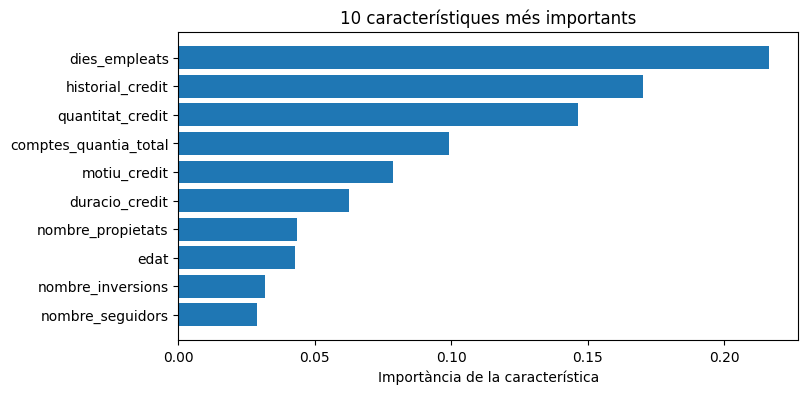


Importància de les característiques:
             Característica  Importància
11            dies_empleats     0.216397
7          historial_credit     0.170411
18         quantitat_credit     0.146591
9     comptes_quantia_total     0.099269
17             motiu_credit     0.078603
16           duracio_credit     0.062430
8         nombre_propietats     0.043410
0                      edat     0.042673
15        nombre_inversions     0.031698
13         nombre_seguidors     0.028807
10  ingressos_totals_anuals     0.026719
5              nombre_fills     0.008623
12                   emocio     0.008449
6                   estudis     0.007656
2              nacionalitat     0.006738
3               estat_civil     0.006163
4           membres_familia     0.005422
14        tipologia_treball     0.005037
1                      sexe     0.004905


In [1398]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Preparació de les dades
def preparar_dades(df):
    # Es transformen les columnes categòriques a números amb LabelEncoder
    columns_to_label_encode = [
        "sexe", "nacionalitat", "estat_civil", "estudis",
        "historial_credit", "emocio", "tipologia_treball", "motiu_credit"
    ]
    
    # Es crea una còpia del dataframe amb el que es treballarà
    df_encoded = df.copy()
    
    # Aplicar LabelEncoder a cada columna categòrica
    label_encoders = {}
    for columna in columns_to_label_encode:
        le = LabelEncoder()
        df_encoded[columna] = le.fit_transform(df_encoded[columna])
        label_encoders[columna] = le
    
    # Se seleccionen X i y
    X = df_encoded.drop(columns=["id_client", "default"])
    y = df_encoded["default"]
    return X, y, label_encoders

# Preparar les dades
X, y, label_encoders = preparar_dades(df_model)

# Divisió en train-test amb estratificació
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Entrenament del model
model = RandomForestClassifier(random_state=42, n_estimators=100, class_weight="balanced")
model.fit(X_train, y_train)

# Avaluació del model
y_pred = model.predict(X_test)

print("Matriu de confusió:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Importància de les variables
importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({"Característica": feature_names, "Importància": importances}).sort_values \
(by="Importància", ascending=False)

# Gràfic de les importàncies
plt.figure(figsize=(8, 4))
plt.barh(importance_df["Característica"][:10], importance_df["Importància"][:10])
plt.xlabel("Importància de la característica")
plt.title("10 característiques més importants")
plt.gca().invert_yaxis()
plt.show()

# Mostrar les importàncies en una taula
print("\nImportància de les característiques:")
print(importance_df)

In [1396]:
# Visualitzar les columnes amb valors nuls i la quantitat que tenen
valors_nulls = df_model.isnull().sum()

columnes_nulls = valors_nulls[valors_nulls > 0]

print(columnes_nulls)

# Es gestionen els nulls per a poder treballar els distints algorismes.


Series([], dtype: int64)


In [1395]:
df_model['nombre_inversions'] = df_model['nombre_inversions'].fillna(df_model['nombre_inversions'].median())

/var/folders/vp/zmdnd3gj74q125lmqlsf_b000000gn/T/ipykernel_9269/3239850654.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_proves['nombre_inversions'] = df_proves['nombre_inversions'].fillna(df_proves['nombre_inversions'].median())


In [1393]:
df_model['nombre_seguidors'] = df_model['nombre_seguidors'].fillna(df_model['nombre_seguidors'].median())

/var/folders/vp/zmdnd3gj74q125lmqlsf_b000000gn/T/ipykernel_9269/1130727008.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_proves['nombre_seguidors'] = df_proves['nombre_seguidors'].fillna(df_proves['nombre_seguidors'].median())


In [1390]:
df_model['emocio'] = df_model['emocio'].fillna(df_model['emocio'].mode()[0])

/var/folders/vp/zmdnd3gj74q125lmqlsf_b000000gn/T/ipykernel_9269/976782807.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_proves['emocio'] = df_proves['emocio'].fillna(df_proves['emocio'].mode()[0])


In [1388]:
df_model['ingressos_totals_anuals'] = df_model['ingressos_totals_anuals'].fillna(df_model['ingressos_totals_anuals'].median())

/var/folders/vp/zmdnd3gj74q125lmqlsf_b000000gn/T/ipykernel_9269/1648563887.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_proves['ingressos_totals_anuals'] = df_proves['ingressos_totals_anuals'].fillna(df_proves['ingressos_totals_anuals'].median())


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuració de l'estil
sns.set(style="whitegrid")

# Columnes a analitzar
categorical_columns = ['sexe', 'nacionalitat', 'estat_civil', 'motiu_credit']
numerical_columns = ['edat', 'membres_familia', 'nombre_fills', 'nombre_propietats', 'quantitat_credit']

# Barplots per a columnes categòriques
for col in categorical_columns:
    plt.figure(figsize=(4, 2))
    sns.countplot(data=df_model, x=col, order=df_model[col].value_counts().index, \
                  palette="viridis", hue=col, dodge=False, legend=False)
    plt.title(f"Distribució de {col}", fontsize=8)
    plt.xticks(rotation=55, fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlabel(col.capitalize(), fontsize=8)
    plt.ylabel("Nombre d'observacions", fontsize=8)
    plt.show()

# Histogrames per a columnes numèriques
for col in numerical_columns:
    plt.figure(figsize=(5, 3))
    sns.histplot(data=df_model, x=col, kde=True, color="darkblue")
    plt.title(f"Distribució de {col}", fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=6) 
    plt.xlabel(col.capitalize(), fontsize=8)
    plt.ylabel("Freqüència", fontsize=8)
    plt.show()


Model: Random Forest
Precisió: 0.94
Matriu de confusió:
[[2311   64]
 [ 129  496]]

Classification Report:
              precision    recall  f1-score   support

           1       0.95      0.97      0.96      2375
           2       0.89      0.79      0.84       625

    accuracy                           0.94      3000
   macro avg       0.92      0.88      0.90      3000
weighted avg       0.93      0.94      0.93      3000


Model: KNN
Precisió: 0.87
Matriu de confusió:
[[2244  131]
 [ 272  353]]

Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.94      0.92      2375
           2       0.73      0.56      0.64       625

    accuracy                           0.87      3000
   macro avg       0.81      0.75      0.78      3000
weighted avg       0.86      0.87      0.86      3000


Model: SVM
Precisió: 0.70
Matriu de confusió:
[[1577  798]
 [ 108  517]]

Classification Report:
              precision    recall  f1-scor

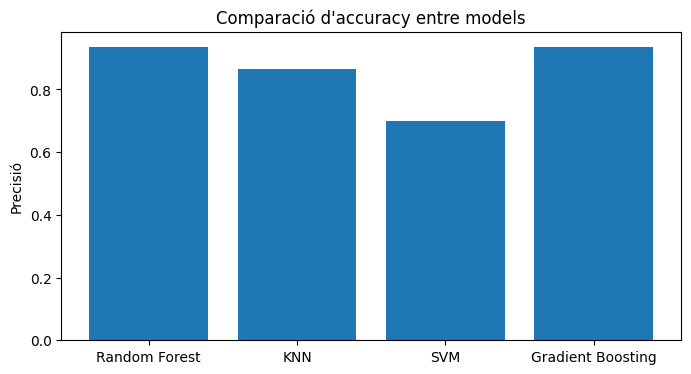

In [1402]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100, class_weight="balanced"),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(random_state=42, class_weight="balanced"),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42, n_estimators=100)
}

resultats = []

for model_name, model in models.items():
    print(f"\nModel: {model_name}")
    
    # Entrenament
    model.fit(X_train, y_train)
    
    # Predicció
    y_pred = model.predict(X_test)
    
    # Mètriques
    acc = accuracy_score(y_test, y_pred)
    matriu_confusio = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    resultats.append({"Model": model_name, "Precisió": acc})
    
    # Mostrem resultats
    print(f"Precisió: {acc:.2f}")
    print("Matriu de confusió:")
    print(matriu_confusio)
    print("\nClassification Report:")
    print(class_report)

# Gràfic comparatiu d'accuracy
df_resultats = pd.DataFrame(resultats)
plt.figure(figsize=(8, 4))
plt.bar(df_resultats["Model"], df_resultats["Precisió"])
plt.title("Comparació d'accuracy entre models")
plt.ylabel("Precisió")
plt.show()